In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "Trihelix"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn001941,MNEMRNLVAALHTKYEQITEKKRSNLTVAGHHHHISANVDAGDRFP...,266,1
1,Achn009891,MFDGVPAEQFHQFIASSRTSVHPLPLSFPLHGSTMQTFPSFDPFPS...,536,1
2,Achn014211,MEVFAADRQISNDVADFPVHLTPFPDAVNMLYDDLTAEIRPPEIEH...,391,1
3,Achn017371,MAPETNDVHELDAHPTNEVNGKQATIEGTNDKSKSQRHPRWTRQET...,429,1
4,Achn020701,MYLSDKPRPIDFYKGGGGERDMVVEVSSVGDLPPHHLQILGDSSGE...,376,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
5370,0.028721,0.0,0.000000,0.010444,0.002611,0.002611,0.000000,0.002611,0.007833,0.007833,...,0.0,0.0,0.000000,0.002611,0.002611,0.000000,0.002611,0.0,0.0,0.000000
1307,0.002047,0.0,0.003071,0.002047,0.001024,0.002047,0.000000,0.001024,0.002047,0.004094,...,0.0,0.0,0.002047,0.001024,0.003071,0.000000,0.002047,0.0,0.0,0.002047
9762,0.000000,0.0,0.004016,0.000000,0.004016,0.004016,0.004016,0.000000,0.000000,0.004016,...,0.0,0.0,0.000000,0.000000,0.004016,0.000000,0.000000,0.0,0.0,0.000000
12140,0.000000,0.0,0.006757,0.000000,0.006757,0.006757,0.000000,0.000000,0.000000,0.006757,...,0.0,0.0,0.000000,0.000000,0.006757,0.000000,0.000000,0.0,0.0,0.000000
11514,0.000000,0.0,0.000000,0.003774,0.003774,0.003774,0.000000,0.000000,0.003774,0.015094,...,0.0,0.0,0.000000,0.000000,0.003774,0.003774,0.000000,0.0,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (9989, 441)
X_test: (2498, 441)
y_train: (9989,)
y_test: (2498,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 58s 470ms/step - accuracy: 0.4844 - loss: 0.6931

 31/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5265 - loss: 0.6903   

 61/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5841 - loss: 0.6720

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6352 - loss: 0.6313

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6707 - loss: 0.5916

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6782 - loss: 0.5824 - val_accuracy: 0.9424 - val_loss: 0.1623


Epoch 2/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9688 - loss: 0.1330

 28/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9486 - loss: 0.1567 

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9481 - loss: 0.1546

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9482 - loss: 0.1524

113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9486 - loss: 0.1501

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9487 - loss: 0.1493 - val_accuracy: 0.9620 - val_loss: 0.1143


Epoch 3/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9844 - loss: 0.0556

 28/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9514 - loss: 0.1239

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9557 - loss: 0.1179

 85/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9570 - loss: 0.1168

114/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9584 - loss: 0.1143

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9587 - loss: 0.1136 - val_accuracy: 0.9615 - val_loss: 0.1098


Epoch 4/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0223

 28/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9813 - loss: 0.0566

 55/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.0617

 82/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9788 - loss: 0.0638

109/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9775 - loss: 0.0663

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0676 - val_accuracy: 0.9675 - val_loss: 0.0952


Epoch 5/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9844 - loss: 0.0498

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9793 - loss: 0.0634

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9801 - loss: 0.0607

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9789 - loss: 0.0628

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9781 - loss: 0.0648

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.0654 - val_accuracy: 0.9479 - val_loss: 0.1340


Epoch 6/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9531 - loss: 0.1514

 30/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9808 - loss: 0.0761

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0701

 85/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0672

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0652

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0643 - val_accuracy: 0.9720 - val_loss: 0.0880


Epoch 7/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9688 - loss: 0.1303

 30/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0483

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0472

 85/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0469

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0467

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0467 - val_accuracy: 0.9755 - val_loss: 0.0822


Epoch 8/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0145

 30/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0215

 58/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0255

 85/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0281

113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0314

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0327 - val_accuracy: 0.9745 - val_loss: 0.0790


Epoch 9/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0177

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0247

 55/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0270

 80/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0301

107/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0330

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0342 - val_accuracy: 0.9805 - val_loss: 0.0776


Epoch 10/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0149

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0426 

 55/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0512

 82/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0539

110/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9804 - loss: 0.0543

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9805 - loss: 0.0540 - val_accuracy: 0.9765 - val_loss: 0.0715


Epoch 11/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0047

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0139

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0187

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0202

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0206

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0207 - val_accuracy: 0.9690 - val_loss: 0.0906


Epoch 12/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0016

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0122

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0135

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0141

110/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0146

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0152 - val_accuracy: 0.9755 - val_loss: 0.0757


Epoch 13/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0020

 28/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0073

 54/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0089

 81/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0091

108/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0095

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0101 - val_accuracy: 0.9640 - val_loss: 0.1061


Epoch 14/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9844 - loss: 0.0608

 28/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0158

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0139

 80/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0132

109/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0138

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0141 - val_accuracy: 0.9805 - val_loss: 0.0703


Epoch 15/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0030

 30/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0127

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0178

 85/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0198

113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0199

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0199 - val_accuracy: 0.9680 - val_loss: 0.1035


Epoch 16/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0031

 28/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0154

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0185

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0183

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0177

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0173 - val_accuracy: 0.9775 - val_loss: 0.0691


Epoch 17/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0027

 28/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0042

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0052

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0060

111/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0062

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0063 - val_accuracy: 0.9705 - val_loss: 0.1000


Epoch 18/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0026

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0026

 58/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0028

 87/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0051

115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0091

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0108 - val_accuracy: 0.9690 - val_loss: 0.0854


Epoch 19/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0130

 28/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0275

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0270

 83/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0250

111/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0229

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0221 - val_accuracy: 0.9790 - val_loss: 0.0849



[Train Accuracy: 99.45% - Test Accuracy: 97.84%]


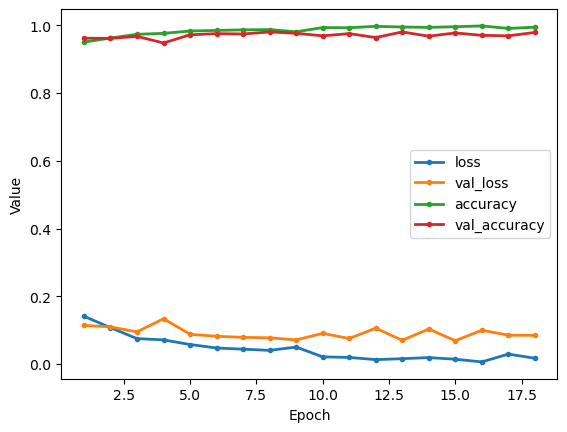

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/79 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


 1/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
5370,0.015707,0.0,0.000000,0.0,0.002618,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,0.000000,0.0,0.001025,0.0,0.000000,0.001025,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9762,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12140,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11514,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (9989, 8965)
X_test: (2498, 8965)
y_train: (9989,)
y_test: (2498,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,295,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,338,561 (8.92 MB)

 Trainable params: 2,338,561 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:02 502ms/step - accuracy: 0.4531 - loss: 0.6932

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4891 - loss: 0.6931    

 16/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5000 - loss: 0.6930

 24/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5253 - loss: 0.6925

 32/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5495 - loss: 0.6912

 40/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5742 - loss: 0.6883

 48/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5977 - loss: 0.6831

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6193 - loss: 0.6750

 65/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6412 - loss: 0.6619

 73/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6587 - loss: 0.6476

 81/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6744 - loss: 0.6319

 89/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6887 - loss: 0.6156

 97/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7016 - loss: 0.5994

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7120 - loss: 0.5855

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7228 - loss: 0.5701

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7327 - loss: 0.5554

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7396 - loss: 0.5448 - val_accuracy: 0.9875 - val_loss: 0.0399


Epoch 2/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0127

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9947 - loss: 0.0222 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9941 - loss: 0.0251

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9936 - loss: 0.0256

 33/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9934 - loss: 0.0255

 41/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9932 - loss: 0.0252

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9932 - loss: 0.0249

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9932 - loss: 0.0244

 65/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9932 - loss: 0.0239

 73/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9933 - loss: 0.0234

 81/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9934 - loss: 0.0229

 89/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9935 - loss: 0.0224

 97/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9935 - loss: 0.0219

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9936 - loss: 0.0215

113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9936 - loss: 0.0212

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9937 - loss: 0.0209

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9937 - loss: 0.0207 - val_accuracy: 0.9890 - val_loss: 0.0330


Epoch 3/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 0.0054

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0040 

 16/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0036

 23/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0035

 30/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0035

 37/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0034

 44/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0034

 51/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0033

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0033

 63/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0034

 68/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0034

 73/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0034

 80/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0034

 85/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0034

 92/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0034

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0034

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0034

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0034

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0034

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9995 - loss: 0.0034 - val_accuracy: 0.9895 - val_loss: 0.0353


Epoch 4/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 5.4062e-04

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5864e-04 

 16/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.9198e-04

 23/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5022e-04

 31/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9309e-04

 39/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4515e-04

 46/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1107e-04

 51/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9111e-04

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.8356e-04

 58/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.6556e-04

 64/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.5473e-04

 71/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.4297e-04

 79/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.7534e-04

 87/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 9.4635e-04

 95/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0012    

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0014

111/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0016

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0018

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9994 - loss: 0.0019 - val_accuracy: 0.9825 - val_loss: 0.0720


Epoch 5/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9844 - loss: 0.0209

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9944 - loss: 0.0093 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9959 - loss: 0.0073

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9968 - loss: 0.0063

 33/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0057

 41/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0053

 50/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0049

 58/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0046

 67/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0043

 75/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0040

 83/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9984 - loss: 0.0038

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0036

 99/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0035

107/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0034

115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0032

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0031

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9988 - loss: 0.0031 - val_accuracy: 0.9845 - val_loss: 0.0776


Epoch 6/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.9591e-04

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0027     

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.0042

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0049

 33/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9980 - loss: 0.0051

 41/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0050

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0048

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0046

 65/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0044

 73/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0042

 81/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9985 - loss: 0.0041

 90/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0040

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0038

106/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0037

113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0036

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0035

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9987 - loss: 0.0034 - val_accuracy: 0.9935 - val_loss: 0.0401


Epoch 7/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 9.7287e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1399e-04 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2303e-04

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5599e-04

 32/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6833e-04

 40/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7198e-04

 48/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7192e-04

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7033e-04

 64/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6856e-04

 72/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6688e-04

 80/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6463e-04

 88/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6228e-04

 96/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5998e-04

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5766e-04

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5541e-04

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5378e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5204e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.5180e-04 - val_accuracy: 0.9930 - val_loss: 0.0398


Epoch 8/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 4.2630e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2470e-05 

 16/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4483e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3065e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4875e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6503e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7215e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7410e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7384e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7174e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6698e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6248e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.5795e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.5470e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.5068e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4699e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4644e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4474e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 7.4295e-05 - val_accuracy: 0.9930 - val_loss: 0.0411


Epoch 9/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 3.6870e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2067e-05 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5295e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6748e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0176e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.3291e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4642e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5402e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6096e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6244e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6216e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5969e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5638e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5341e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5015e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4820e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.4708e-05 - val_accuracy: 0.9935 - val_loss: 0.0428


Epoch 10/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 1.8398e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0208e-05 

 18/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4369e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5445e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6090e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6413e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6764e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7010e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7121e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7178e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7313e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7382e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7416e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7537e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7644e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7709e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.7721e-05 - val_accuracy: 0.9930 - val_loss: 0.0437


Epoch 11/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 1.1243e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4553e-05 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1333e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2517e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2094e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1464e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0988e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0346e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9858e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9461e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9100e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8852e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8780e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8728e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8656e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8543e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.8483e-05 - val_accuracy: 0.9935 - val_loss: 0.0454


Epoch 12/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.7578e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.0291e-05 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2923e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4911e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7260e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8902e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6457e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4237e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9839e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6951e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2571e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6669e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9668e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1801e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3678e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.5507e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.6505e-05 - val_accuracy: 0.9940 - val_loss: 0.0462


Epoch 13/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.1346e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1925e-05 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5142e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8138e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9910e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1612e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3385e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4404e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4914e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5138e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5168e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5097e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4982e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4837e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4650e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4446e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.4341e-05 - val_accuracy: 0.9935 - val_loss: 0.0464


Epoch 14/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 2.3255e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8142e-05 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6157e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6573e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6516e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6519e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6535e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6581e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6580e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6523e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6447e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6339e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6234e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6133e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6070e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5995e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.5968e-05 - val_accuracy: 0.9935 - val_loss: 0.0472


Epoch 15/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 1.0068e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9302e-06 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3846e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5679e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8473e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9214e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9287e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9052e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8719e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8342e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8005e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7614e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7187e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6784e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6422e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6100e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.5873e-05 - val_accuracy: 0.9935 - val_loss: 0.0480


Epoch 16/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 6.5547e-06

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5126e-05 

 14/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.4919e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.4775e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 1.4205e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.3529e-05 

 39/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.3042e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2796e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2775e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2676e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2582e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2466e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2329e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2210e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2113e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2032e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1945e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1863e-05 - val_accuracy: 0.9935 - val_loss: 0.0486


Epoch 17/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.3122e-06

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1976e-06 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7540e-06

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8593e-06

 28/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 5.9918e-06

 34/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 6.6063e-06

 41/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 7.2199e-06

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.6797e-06 

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.9682e-06

 66/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.1459e-06

 74/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.2715e-06

 82/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.4495e-06

 90/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.6735e-06

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8784e-06

107/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.0482e-06

115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.1505e-06

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.1902e-06

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.2069e-06

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 9.2345e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 9.2517e-06 - val_accuracy: 0.9935 - val_loss: 0.0493


Epoch 18/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 1.0000 - loss: 3.0310e-06

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.0837e-06 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.2682e-06

 23/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4680e-06

 31/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4077e-06

 38/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6804e-06

 45/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7492e-06

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0368e-06

 60/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.3956e-06

 68/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6453e-06

 76/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.7746e-06

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8132e-06

 92/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8293e-06

100/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8167e-06

108/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.7766e-06

116/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.7415e-06

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.6915e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.6770e-06 - val_accuracy: 0.9935 - val_loss: 0.0503


Epoch 19/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.1749e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4624e-05 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2325e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0761e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9084e-06

 42/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2881e-06

 50/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8670e-06

 58/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5068e-06

 66/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2366e-06

 75/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9844e-06

 83/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.8145e-06

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6603e-06

 99/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.5229e-06

107/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4004e-06

115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3144e-06

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.2421e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.2176e-06 - val_accuracy: 0.9935 - val_loss: 0.0505


Epoch 20/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.5631e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2736e-05 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0489e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5837e-06

 33/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0653e-06

 41/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6310e-06

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.2670e-06

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.9495e-06

 65/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.7306e-06

 73/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.5357e-06

 81/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3879e-06

 89/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4856e-06

 97/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6565e-06

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7645e-06

113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2065e-06

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7612e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 9.0511e-06 - val_accuracy: 0.9900 - val_loss: 0.0532


Epoch 21/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 5.6893e-06

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0507e-05 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0419e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0729e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1318e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1626e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1699e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1777e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1721e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1576e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1430e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1312e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1192e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1052e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0901e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0752e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0697e-05 - val_accuracy: 0.9930 - val_loss: 0.0505


Epoch 22/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 3.5466e-06

  9/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1192e-06 

 17/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9767e-06

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7643e-06

 33/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6630e-06

 41/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8972e-06

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0188e-06

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0991e-06

 65/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1269e-06

 73/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1144e-06

 81/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0760e-06

 89/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1078e-06

 97/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2204e-06

106/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3000e-06

114/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3523e-06

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3856e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.3967e-06 - val_accuracy: 0.9925 - val_loss: 0.0509



[Train Accuracy: 100.00% - Test Accuracy: 99.56%]


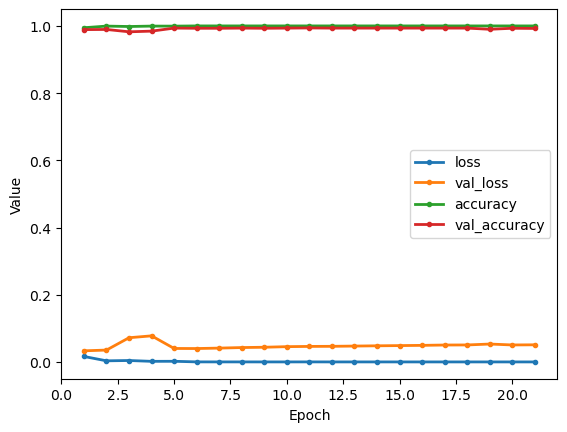

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/79 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

54/79 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 1/79 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

49/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
5370,0.013123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9762,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12140,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11514,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      40,006,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,047,873 (152.77 MB)

 Trainable params: 40,047,873 (152.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:25 691ms/step - accuracy: 0.5469 - loss: 0.6931

  2/125 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.5352 - loss: 0.6931 

  3/125 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - accuracy: 0.5304 - loss: 0.6931

  4/125 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.5267 - loss: 0.6930

  5/125 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.5201 - loss: 0.6931

  6/125 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.5163 - loss: 0.6932

  7/125 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.5134 - loss: 0.6932

  8/125 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.5109 - loss: 0.6932

  9/125 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.5092 - loss: 0.6932

 10/125 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.5086 - loss: 0.6931

 11/125 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.5084 - loss: 0.6931

 12/125 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.5090 - loss: 0.6931

 13/125 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.5109 - loss: 0.6930

 14/125 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.5126 - loss: 0.6930

 15/125 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.5141 - loss: 0.6929

 16/125 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.5153 - loss: 0.6928

 17/125 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.5163 - loss: 0.6928

 18/125 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.5170 - loss: 0.6927

 19/125 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.5175 - loss: 0.6926

 20/125 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.5181 - loss: 0.6925

 21/125 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.5193 - loss: 0.6924

 22/125 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.5211 - loss: 0.6923

 23/125 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.5232 - loss: 0.6922

 24/125 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.5257 - loss: 0.6921

 25/125 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.5284 - loss: 0.6920

 26/125 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.5314 - loss: 0.6918

 27/125 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.5346 - loss: 0.6917

 28/125 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.5380 - loss: 0.6915

 29/125 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.5413 - loss: 0.6913

 30/125 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.5446 - loss: 0.6911

 31/125 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.5480 - loss: 0.6909

 32/125 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.5514 - loss: 0.6906

 33/125 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.5548 - loss: 0.6903

 34/125 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.5582 - loss: 0.6901

 35/125 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.5615 - loss: 0.6898

 36/125 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.5648 - loss: 0.6894

 37/125 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.5680 - loss: 0.6891

 38/125 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.5713 - loss: 0.6887

 39/125 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.5745 - loss: 0.6883

 40/125 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.5777 - loss: 0.6879

 41/125 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.5808 - loss: 0.6874

 42/125 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.5839 - loss: 0.6869

 43/125 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.5869 - loss: 0.6864

 44/125 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.5899 - loss: 0.6858

 45/125 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.5929 - loss: 0.6852

 46/125 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.5958 - loss: 0.6845 

 47/125 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.5987 - loss: 0.6838

 48/125 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6016 - loss: 0.6830

 49/125 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6044 - loss: 0.6822

 50/125 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6072 - loss: 0.6814

 51/125 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6100 - loss: 0.6805

 52/125 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6127 - loss: 0.6795

 53/125 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.6154 - loss: 0.6786

 54/125 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6180 - loss: 0.6775

 55/125 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6206 - loss: 0.6765

 56/125 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6232 - loss: 0.6754

 57/125 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6257 - loss: 0.6743

 58/125 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.6282 - loss: 0.6731

 59/125 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6307 - loss: 0.6718

 60/125 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6331 - loss: 0.6706

 61/125 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.6355 - loss: 0.6692

 62/125 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.6378 - loss: 0.6679

 63/125 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.6401 - loss: 0.6665

 64/125 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.6424 - loss: 0.6650

 65/125 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.6447 - loss: 0.6635

 66/125 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.6470 - loss: 0.6620

 67/125 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6492 - loss: 0.6604

 68/125 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6514 - loss: 0.6589

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.6536 - loss: 0.6572

 70/125 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6557 - loss: 0.6556

 71/125 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6578 - loss: 0.6539

 72/125 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.6599 - loss: 0.6522

 73/125 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6620 - loss: 0.6504

 74/125 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.6641 - loss: 0.6486

 75/125 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6661 - loss: 0.6468

 76/125 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6681 - loss: 0.6450

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6701 - loss: 0.6432

 78/125 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.6720 - loss: 0.6413

 79/125 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.6740 - loss: 0.6394

 80/125 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.6759 - loss: 0.6375

 81/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.6777 - loss: 0.6356

 82/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.6796 - loss: 0.6337

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.6814 - loss: 0.6318

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.6832 - loss: 0.6299

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.6850 - loss: 0.6279

 86/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6868 - loss: 0.6260

 87/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6885 - loss: 0.6241

 88/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6902 - loss: 0.6221

 89/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6919 - loss: 0.6201

 90/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6936 - loss: 0.6182

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6952 - loss: 0.6162

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6969 - loss: 0.6143

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6985 - loss: 0.6123

 94/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7001 - loss: 0.6103

 95/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7017 - loss: 0.6084

 96/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7032 - loss: 0.6064

 97/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7048 - loss: 0.6044

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7063 - loss: 0.6024

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7078 - loss: 0.6005

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7093 - loss: 0.5985

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7108 - loss: 0.5966

102/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7123 - loss: 0.5946

103/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7137 - loss: 0.5926

104/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7151 - loss: 0.5907

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7165 - loss: 0.5887

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7179 - loss: 0.5868

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7193 - loss: 0.5849

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7207 - loss: 0.5829

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.7221 - loss: 0.5810

110/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7234 - loss: 0.5791

111/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7247 - loss: 0.5772

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7260 - loss: 0.5753

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7273 - loss: 0.5734

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7286 - loss: 0.5715

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7299 - loss: 0.5696

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7312 - loss: 0.5677

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.7324 - loss: 0.5659

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7336 - loss: 0.5640

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7349 - loss: 0.5622

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7361 - loss: 0.5603

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7373 - loss: 0.5585

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7385 - loss: 0.5567

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7396 - loss: 0.5549

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7408 - loss: 0.5531

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7419 - loss: 0.5513

125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.7431 - loss: 0.5496 - val_accuracy: 0.9915 - val_loss: 0.0249


Epoch 2/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 29s 237ms/step - accuracy: 1.0000 - loss: 0.0025

  2/125 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 1.0000 - loss: 0.0028

  3/125 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 1.0000 - loss: 0.0030

  4/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 0.0033

  5/125 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 1.0000 - loss: 0.0035

  6/125 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.9996 - loss: 0.0042

  7/125 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9993 - loss: 0.0045

  8/125 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.9989 - loss: 0.0054

  9/125 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.9986 - loss: 0.0061

 10/125 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9985 - loss: 0.0065

 11/125 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.9983 - loss: 0.0068

 12/125 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.9983 - loss: 0.0070

 13/125 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.9982 - loss: 0.0072

 14/125 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9982 - loss: 0.0073

 15/125 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9982 - loss: 0.0074

 16/125 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.9982 - loss: 0.0075

 17/125 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9982 - loss: 0.0076

 18/125 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.9982 - loss: 0.0076

 19/125 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.9982 - loss: 0.0076

 20/125 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.9982 - loss: 0.0077

 21/125 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.9982 - loss: 0.0077

 22/125 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.9982 - loss: 0.0077

 23/125 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9982 - loss: 0.0077

 24/125 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.9983 - loss: 0.0077

 25/125 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.9983 - loss: 0.0077

 26/125 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.9983 - loss: 0.0077

 27/125 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.9983 - loss: 0.0077

 28/125 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.9983 - loss: 0.0076

 29/125 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9984 - loss: 0.0076

 30/125 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9984 - loss: 0.0076

 31/125 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9984 - loss: 0.0075

 32/125 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9984 - loss: 0.0075

 33/125 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9984 - loss: 0.0075

 34/125 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9985 - loss: 0.0075

 35/125 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9985 - loss: 0.0074

 36/125 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9985 - loss: 0.0074

 37/125 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9985 - loss: 0.0074

 38/125 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9985 - loss: 0.0074

 39/125 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9985 - loss: 0.0073

 40/125 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9986 - loss: 0.0073

 41/125 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 42/125 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 43/125 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 44/125 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 45/125 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 46/125 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 47/125 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 48/125 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 49/125 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 51/125 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9986 - loss: 0.0073 

 52/125 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 53/125 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9986 - loss: 0.0073

 54/125 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9986 - loss: 0.0073

 55/125 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 56/125 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 59/125 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 60/125 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 61/125 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 67/125 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 68/125 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9986 - loss: 0.0073

 74/125 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9986 - loss: 0.0073

 75/125 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9986 - loss: 0.0073

 76/125 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9986 - loss: 0.0073

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9986 - loss: 0.0072

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9986 - loss: 0.0072

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9986 - loss: 0.0072

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9986 - loss: 0.0072

 81/125 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9985 - loss: 0.0072

 82/125 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9985 - loss: 0.0072

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9985 - loss: 0.0072

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9985 - loss: 0.0072

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9985 - loss: 0.0072

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9985 - loss: 0.0072

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9985 - loss: 0.0072

 88/125 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9985 - loss: 0.0072

 89/125 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9985 - loss: 0.0071

 90/125 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9985 - loss: 0.0071

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9985 - loss: 0.0071

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9985 - loss: 0.0071

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9985 - loss: 0.0071

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9985 - loss: 0.0071

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9985 - loss: 0.0071

 96/125 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9985 - loss: 0.0071

 97/125 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9985 - loss: 0.0071

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9985 - loss: 0.0071

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9985 - loss: 0.0071

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9985 - loss: 0.0071

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9985 - loss: 0.0070

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9985 - loss: 0.0070

103/125 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9985 - loss: 0.0070

104/125 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9985 - loss: 0.0070

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9985 - loss: 0.0070

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9985 - loss: 0.0070

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9985 - loss: 0.0070

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9985 - loss: 0.0070

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9985 - loss: 0.0070

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9985 - loss: 0.0070

111/125 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9985 - loss: 0.0070

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9985 - loss: 0.0070

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9985 - loss: 0.0070

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9985 - loss: 0.0070

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9985 - loss: 0.0070

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9985 - loss: 0.0069

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9985 - loss: 0.0069

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9985 - loss: 0.0069

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9985 - loss: 0.0069

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9985 - loss: 0.0069

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9985 - loss: 0.0069

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9985 - loss: 0.0069

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9985 - loss: 0.0069

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9985 - loss: 0.0069

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9985 - loss: 0.0069

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.9985 - loss: 0.0069 - val_accuracy: 0.9960 - val_loss: 0.0154


Epoch 3/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 1.0000 - loss: 8.7842e-04

  2/125 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 1.0000 - loss: 8.7870e-04

  3/125 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 0.0010    

  4/125 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 0.0012

  5/125 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 0.0012

  6/125 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 0.0013

  7/125 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 1.0000 - loss: 0.0013

  8/125 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 0.0013

  9/125 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 0.0012

 10/125 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 1.0000 - loss: 0.0012

 11/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 0.0012

 12/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 0.0012

 13/125 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 0.0012

 14/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 0.0012

 15/125 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 0.0012

 16/125 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 17/125 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 18/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 0.0013

 19/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 0.0013

 20/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 0.0013

 21/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 0.0013

 22/125 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 23/125 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 24/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 25/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 26/125 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 0.0013

 27/125 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 0.0013

 28/125 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 0.0013

 29/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 30/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 31/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 32/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 33/125 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 0.0013

 34/125 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 0.0013

 35/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 36/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 37/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 38/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 39/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 40/125 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 41/125 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 0.0013

 42/125 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 0.0013

 43/125 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 0.0013

 44/125 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 0.0013

 45/125 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 0.0013

 46/125 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 0.0013

 47/125 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 0.0013 

 48/125 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 0.0013

 49/125 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 50/125 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 51/125 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 52/125 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 53/125 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 54/125 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 55/125 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 56/125 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 57/125 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 58/125 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 59/125 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 60/125 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 61/125 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 63/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 64/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 65/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 66/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 67/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 68/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 71/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 72/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 73/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 74/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 75/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 76/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 78/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 79/125 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 80/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 81/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 82/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0012

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 86/125 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 87/125 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 88/125 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 89/125 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 90/125 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 94/125 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 95/125 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 96/125 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 97/125 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0011

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0011

102/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0011

103/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0011

104/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0011

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0011

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0011

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0011

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0011

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0011

110/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0011

111/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0011

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0011

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0011

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0011

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0011

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0011

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0011

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9950 - val_loss: 0.0177


Epoch 4/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 39s 319ms/step - accuracy: 1.0000 - loss: 1.2700e-04

  2/125 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 1.8202e-04

  3/125 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 1.0000 - loss: 2.2358e-04

  4/125 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 1.0000 - loss: 2.6698e-04

  5/125 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 1.0000 - loss: 2.8989e-04

  6/125 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 1.0000 - loss: 3.3220e-04

  7/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 3.5617e-04

  8/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 3.6980e-04

  9/125 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 3.7763e-04

 10/125 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 1.0000 - loss: 3.8962e-04

 11/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 3.9844e-04

 12/125 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 4.0367e-04

 13/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 4.0753e-04

 14/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 4.1533e-04

 15/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 4.2105e-04

 16/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 4.2484e-04

 17/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 4.2756e-04

 18/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 4.2934e-04

 19/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 4.3080e-04

 20/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 4.3154e-04

 21/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 4.3188e-04

 22/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 4.3187e-04

 23/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 4.3155e-04

 24/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 4.3080e-04

 25/125 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 4.2974e-04

 26/125 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 4.2845e-04

 27/125 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 4.2708e-04

 28/125 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 4.2552e-04

 29/125 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 4.2487e-04

 30/125 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 4.2403e-04

 31/125 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 4.2311e-04

 32/125 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 4.2209e-04

 33/125 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 4.2090e-04

 34/125 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 4.1955e-04

 35/125 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 4.1817e-04

 36/125 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 4.1677e-04

 37/125 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 4.1531e-04

 38/125 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 4.1378e-04

 39/125 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 4.1222e-04

 40/125 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 4.1075e-04

 41/125 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 4.0931e-04

 42/125 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 4.0782e-04

 43/125 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 4.0630e-04

 44/125 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 4.0477e-04

 45/125 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 4.0324e-04

 46/125 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 4.0224e-04

 47/125 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 4.0123e-04

 48/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 4.0021e-04 

 49/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9921e-04

 50/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9815e-04

 51/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9703e-04

 52/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9644e-04

 53/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9579e-04

 54/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9525e-04

 55/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 3.9465e-04

 56/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.9399e-04

 57/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.9330e-04

 58/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.9256e-04

 59/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.9201e-04

 60/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.9141e-04

 61/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.9084e-04

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.9031e-04

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 3.8979e-04

 64/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 3.8922e-04

 65/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 3.8864e-04

 66/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 3.8805e-04

 67/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 3.8749e-04

 68/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 3.8693e-04

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.8636e-04

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 3.8577e-04

 71/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.8516e-04

 72/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.8455e-04

 73/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.8392e-04

 74/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.8328e-04

 75/125 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.8266e-04

 76/125 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.8201e-04

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.8135e-04

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.8070e-04

 79/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.8005e-04

 80/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.7941e-04

 81/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.7876e-04

 82/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.7810e-04

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.7743e-04

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.7676e-04

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.7608e-04

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.7539e-04

 87/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.7468e-04

 88/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.7399e-04

 89/125 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 3.7330e-04

 90/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.7262e-04

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.7194e-04

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.7125e-04

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.7057e-04

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.6988e-04

 95/125 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.6919e-04

 96/125 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.6851e-04

 97/125 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.6787e-04

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.6729e-04

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.6672e-04

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.6616e-04

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.6559e-04

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.6501e-04

103/125 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.6445e-04

104/125 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.6390e-04

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.6333e-04

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.6276e-04

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 3.6218e-04

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 3.6159e-04

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 3.6102e-04

110/125 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 3.6046e-04

111/125 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 3.5989e-04

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 3.5932e-04

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 3.5874e-04

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 3.5816e-04

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 3.5758e-04

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 3.5699e-04

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 3.5641e-04

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.5585e-04

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.5528e-04

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.5472e-04

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.5416e-04

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.5360e-04

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.5305e-04

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 3.5250e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 3.5196e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 1.0000 - loss: 3.5143e-04 - val_accuracy: 0.9945 - val_loss: 0.0192


Epoch 5/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 35s 284ms/step - accuracy: 1.0000 - loss: 1.4221e-04

  2/125 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 1.0000 - loss: 1.3521e-04

  3/125 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 1.0000 - loss: 1.4073e-04

  4/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 1.4011e-04

  5/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 1.3862e-04

  6/125 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 1.0000 - loss: 1.3748e-04

  7/125 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 1.0000 - loss: 1.3663e-04

  8/125 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 1.0000 - loss: 1.3549e-04

  9/125 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 1.0000 - loss: 1.3554e-04

 10/125 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 1.0000 - loss: 1.3574e-04

 11/125 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 1.0000 - loss: 1.3597e-04

 12/125 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 1.0000 - loss: 1.3623e-04

 13/125 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 1.0000 - loss: 1.3677e-04

 14/125 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 1.0000 - loss: 1.3713e-04

 15/125 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 1.0000 - loss: 1.3722e-04

 16/125 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 1.0000 - loss: 1.3713e-04

 17/125 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 1.3687e-04

 18/125 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 1.3657e-04

 19/125 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 1.3909e-04

 20/125 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 1.0000 - loss: 1.4116e-04

 21/125 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 1.0000 - loss: 1.4277e-04

 22/125 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 1.0000 - loss: 1.4402e-04

 23/125 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.4491e-04

 24/125 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 1.0000 - loss: 1.4573e-04

 25/125 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.4647e-04

 26/125 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 1.0000 - loss: 1.4707e-04

 27/125 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 1.4760e-04

 28/125 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 1.4811e-04

 29/125 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 1.4855e-04

 30/125 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.4889e-04

 31/125 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.4919e-04

 32/125 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 1.4939e-04

 33/125 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 1.4949e-04

 34/125 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.4954e-04

 35/125 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.4960e-04

 36/125 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.4963e-04

 37/125 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.4974e-04

 38/125 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.4981e-04

 39/125 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.4989e-04

 40/125 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.4996e-04

 41/125 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.5005e-04

 42/125 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.5008e-04

 43/125 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.5010e-04

 44/125 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.5013e-04

 45/125 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.5012e-04

 46/125 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.5010e-04

 47/125 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.5004e-04

 48/125 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.4995e-04

 49/125 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.4987e-04 

 50/125 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.4979e-04

 51/125 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.4970e-04

 52/125 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.4961e-04

 53/125 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.4950e-04

 54/125 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.4940e-04

 55/125 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.4930e-04

 56/125 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.4918e-04

 57/125 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.4904e-04

 58/125 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.4889e-04

 59/125 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.4872e-04

 60/125 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.4856e-04

 61/125 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.4838e-04

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.4819e-04

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.4799e-04

 64/125 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 1.4778e-04

 65/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.4756e-04

 66/125 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 1.4735e-04

 67/125 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 1.4714e-04

 68/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.4692e-04

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.4668e-04

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 1.4644e-04

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 1.4620e-04

 72/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.4596e-04

 73/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.4572e-04

 74/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.4549e-04

 75/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.4526e-04

 76/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.4503e-04

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.4481e-04

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.4458e-04

 79/125 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.4435e-04

 80/125 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.4413e-04

 81/125 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.4391e-04

 82/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.4369e-04

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.4348e-04

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.4328e-04

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.4306e-04

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.4285e-04

 87/125 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.4264e-04

 88/125 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.4244e-04

 89/125 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.4223e-04

 90/125 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.4203e-04

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.4182e-04

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.4161e-04

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.4139e-04

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.4119e-04

 95/125 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4098e-04

 96/125 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4078e-04

 97/125 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4058e-04

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4039e-04

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4020e-04

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4003e-04

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.3985e-04

102/125 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.3967e-04

103/125 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.3949e-04

104/125 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.3931e-04

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.3912e-04

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.3893e-04

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.3874e-04

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.3856e-04

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.3838e-04

110/125 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.3820e-04

111/125 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.3802e-04

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.3784e-04

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.3766e-04

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.3749e-04

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.3731e-04

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.3714e-04

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.3696e-04

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.3679e-04

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.3663e-04

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.3647e-04

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.3631e-04

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.3615e-04

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.3599e-04

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.3582e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.3567e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 1.0000 - loss: 1.3551e-04 - val_accuracy: 0.9940 - val_loss: 0.0218


Epoch 6/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 50s 409ms/step - accuracy: 1.0000 - loss: 5.2856e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 1.0000 - loss: 6.5881e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 1.0000 - loss: 6.5666e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 6.6227e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 7.2586e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 7.6050e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 7.7932e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 7.8695e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 7.9154e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 8.1609e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 8.3479e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 8.5821e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 8.7612e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 8.8772e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 8.9539e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 9.0118e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 9.0649e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 9.0929e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 9.1175e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 9.1308e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 9.1352e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 9.1454e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 9.1437e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 9.1414e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 9.2770e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 9.3883e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 9.4817e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 9.5675e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 9.6436e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 9.7141e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 9.7762e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.8265e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.9086e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 9.9791e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.0045e-04

 36/125 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.0111e-04

 37/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.0170e-04

 38/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.0220e-04

 39/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.0263e-04

 40/125 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.0298e-04

 41/125 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.0332e-04

 42/125 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.0361e-04

 43/125 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.0385e-04

 44/125 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.0405e-04

 45/125 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.0423e-04

 46/125 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.0436e-04

 47/125 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.0453e-04 

 48/125 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.0469e-04

 49/125 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.0482e-04

 50/125 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.0492e-04

 51/125 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.0500e-04

 52/125 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.0504e-04

 53/125 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.0509e-04

 54/125 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 1.0513e-04

 55/125 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.0515e-04

 56/125 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.0516e-04

 57/125 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.0515e-04

 58/125 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.0513e-04

 59/125 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.0694e-04

 60/125 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.0865e-04

 61/125 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.1045e-04

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 1.1221e-04

 63/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1386e-04

 64/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1543e-04

 65/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1691e-04

 66/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1831e-04

 67/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.1966e-04

 68/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.2094e-04

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.2216e-04

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 1.2333e-04

 71/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.2448e-04

 72/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.2557e-04

 73/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.2660e-04

 74/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.2760e-04

 75/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.2854e-04

 76/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.2945e-04

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.3031e-04

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.3113e-04

 79/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3192e-04

 80/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3276e-04

 81/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3357e-04

 82/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3434e-04

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3507e-04

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3577e-04

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.3644e-04

 86/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3708e-04

 87/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3771e-04

 88/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3831e-04

 89/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3889e-04

 90/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.3947e-04

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.4001e-04

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.4054e-04

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 1.4105e-04

 94/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4153e-04

 95/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4198e-04

 96/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4242e-04

 97/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4283e-04

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4323e-04

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4361e-04

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4397e-04

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 1.4432e-04

102/125 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.4464e-04

103/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4495e-04

104/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4524e-04

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4552e-04

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4579e-04

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4604e-04

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4627e-04

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4648e-04

110/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.4669e-04

111/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.4688e-04

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.4707e-04

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.4724e-04

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.4741e-04

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.4757e-04

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.4772e-04

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 1.4787e-04

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4801e-04

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4814e-04

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4826e-04

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4837e-04

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4847e-04

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4856e-04

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4865e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.4873e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 1.0000 - loss: 1.4882e-04 - val_accuracy: 0.9950 - val_loss: 0.0200


Epoch 7/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 49s 397ms/step - accuracy: 1.0000 - loss: 5.7293e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 1.0000 - loss: 5.4737e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 1.0000 - loss: 5.6200e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 1.0000 - loss: 5.8815e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 1.0000 - loss: 6.1116e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 1.0000 - loss: 6.2305e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 1.0000 - loss: 6.2604e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 1.0000 - loss: 6.2402e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 6.2524e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 6.2566e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 1.0000 - loss: 6.2317e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 6.2234e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 6.3569e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 6.4785e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 1.0000 - loss: 6.5614e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 1.0000 - loss: 6.6343e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 1.0000 - loss: 6.6869e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 1.0000 - loss: 6.7252e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 1.0000 - loss: 6.7490e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 6.7590e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 6.7605e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 1.0000 - loss: 6.7580e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 1.0000 - loss: 6.7511e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 6.7424e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 6.7349e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 6.7476e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 6.7560e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 6.7613e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 6.7623e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 6.7610e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 6.7589e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 6.7528e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 6.7429e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 6.7322e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 6.7230e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 6.7109e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 6.6991e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 1.0000 - loss: 6.6857e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 1.0000 - loss: 6.6732e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 1.0000 - loss: 6.6606e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 1.0000 - loss: 6.6465e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 1.0000 - loss: 6.6330e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 1.0000 - loss: 6.6181e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 1.0000 - loss: 6.6031e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 1.0000 - loss: 6.5874e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - accuracy: 1.0000 - loss: 6.5720e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 1.0000 - loss: 6.5564e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 1.0000 - loss: 6.5407e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 1.0000 - loss: 6.5276e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 1.0000 - loss: 6.5143e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 1.0000 - loss: 6.5027e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 1.0000 - loss: 6.4916e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 1.0000 - loss: 6.4799e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 1.0000 - loss: 6.4682e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 1.0000 - loss: 6.4580e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 1.0000 - loss: 6.4769e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 1.0000 - loss: 6.4956e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 1.0000 - loss: 6.5125e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 1.0000 - loss: 6.5274e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 1.0000 - loss: 6.5408e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 1.0000 - loss: 6.5522e-05 

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 1.0000 - loss: 6.5622e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 1.0000 - loss: 6.5729e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 1.0000 - loss: 6.5839e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 1.0000 - loss: 6.5943e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 1.0000 - loss: 6.6037e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 1.0000 - loss: 6.6120e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 1.0000 - loss: 6.6193e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 6.6302e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 6.6405e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 6.6509e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 6.6605e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 6.6702e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 6.6800e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 6.6888e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 6.6966e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 6.7041e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 6.7110e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 6.7171e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 6.7228e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 6.7279e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 6.7323e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 6.7362e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 6.7410e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 6.7452e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 6.7487e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 6.7544e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 6.7593e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 6.7646e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 6.7693e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 6.7734e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.7769e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.7799e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.7823e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.7861e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.7893e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.7923e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.7948e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 6.7971e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.7989e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.8011e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.8028e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.8044e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.8055e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 6.8062e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 6.8068e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 6.8079e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 6.8089e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 6.8098e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 6.8104e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.8107e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.8136e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.8164e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.8190e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.8211e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.8228e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.8244e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.8262e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 6.8276e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.8292e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.8305e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.8314e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.8321e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.8323e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 6.8325e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 1.0000 - loss: 6.8326e-05 - val_accuracy: 0.9950 - val_loss: 0.0220


Epoch 8/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 41s 334ms/step - accuracy: 1.0000 - loss: 4.2981e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 1.0000 - loss: 4.3593e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 1.0000 - loss: 4.8662e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 4.8389e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 1.0000 - loss: 4.7772e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 1.0000 - loss: 4.6836e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 1.0000 - loss: 4.5618e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 1.0000 - loss: 4.4395e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 1.0000 - loss: 4.3262e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 1.0000 - loss: 4.2143e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 1.0000 - loss: 4.1306e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 4.0561e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 1.0000 - loss: 4.0071e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 1.0000 - loss: 3.9687e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 3.9304e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 3.9026e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 3.8758e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 3.8517e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 3.8317e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 3.8131e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 3.7944e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 3.7755e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 3.7577e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 1.0000 - loss: 3.7475e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 3.7448e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 3.7433e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 3.7400e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 3.7384e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 3.7352e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 3.7317e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 1.0000 - loss: 3.7288e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 3.7296e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 3.7294e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 3.7277e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 3.7264e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 3.7317e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 3.7377e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 3.7459e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 3.7536e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 3.7612e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 3.7699e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 3.7772e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 3.7927e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 3.8073e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 3.8208e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.8341e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.8484e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.8657e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.8817e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.8996e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.9170e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 3.9326e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.9474e-05 

 54/125 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.9632e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.9777e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 3.9917e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.0049e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.0189e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 4.0319e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.0436e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.0546e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.0647e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.0735e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.0812e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.0881e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.0947e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 4.1006e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 4.1061e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 4.1118e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 4.1171e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 4.1217e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 4.1258e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 4.1295e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 4.1328e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 4.1356e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 4.1388e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 4.1417e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 4.1443e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 4.1471e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 4.1498e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 4.1521e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.1542e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.1558e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.1570e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.1578e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.1582e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.1586e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 4.1614e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 4.1638e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 4.1658e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 4.1674e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 4.1687e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 4.1700e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 4.1718e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 4.1735e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 4.1750e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 4.1764e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 4.1778e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 4.1790e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 4.1801e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 4.1814e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 4.1823e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 4.1831e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.1835e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.1841e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.1846e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.1851e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.1865e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.1880e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 4.1893e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 4.1906e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 4.1918e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 4.1930e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 4.1939e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 4.1947e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 4.1954e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.1959e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.1963e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.1965e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.1966e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.1965e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.1962e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.1958e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.1953e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.1949e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 1.0000 - loss: 4.1946e-05 - val_accuracy: 0.9945 - val_loss: 0.0239


Epoch 9/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 35s 287ms/step - accuracy: 1.0000 - loss: 3.2936e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 1.0000 - loss: 3.0892e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 1.0000 - loss: 2.9082e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 2.8830e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 2.9115e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 1.0000 - loss: 2.9466e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 1.0000 - loss: 2.9656e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.9706e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 1.0000 - loss: 2.9625e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 2.9545e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 2.9390e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 2.9293e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 2.9110e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 2.8980e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 2.8841e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 2.8688e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 2.8509e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.8421e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.8336e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.8258e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 2.8181e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.8094e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.7999e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 2.7921e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.7823e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.7754e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.7714e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 2.7681e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.7661e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.7630e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.7600e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.7567e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.7526e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 2.7480e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 2.7428e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.7383e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.7342e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.7333e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.7318e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.7302e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.7298e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.7288e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.7282e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.7275e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.7363e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.7450e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.7541e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 2.7621e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.7691e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.7754e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.7816e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.7876e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 2.7953e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 2.8023e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 2.8087e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 2.8143e-05 

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 2.8215e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 2.8287e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 2.8356e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 2.8418e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 2.8471e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 2.8527e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 2.8578e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 2.8633e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 2.8687e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.8738e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.8787e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.8832e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.8872e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.8911e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 2.8953e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 2.8994e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 2.9032e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 2.9070e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 2.9111e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 2.9148e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 2.9189e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 2.9226e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 2.9260e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 2.9291e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 2.9321e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 2.9348e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 2.9371e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 2.9395e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 2.9431e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 2.9463e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 2.9492e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.9519e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.9543e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.9564e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.9584e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.9602e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.9618e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.9633e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 2.9647e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 2.9660e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 2.9672e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 2.9683e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 2.9701e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 2.9718e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 2.9734e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 1.0000 - loss: 2.9748e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 2.9760e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 2.9770e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 2.9780e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 1.0000 - loss: 2.9817e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 2.9852e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 2.9887e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 2.9919e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 2.9949e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 2.9978e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 3.0006e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 3.0032e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 3.0057e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 3.0082e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 3.0106e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 3.0128e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 3.0149e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 3.0170e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 3.0191e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 3.0212e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 3.0232e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 3.0251e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 3.0269e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 3.0286e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 1.0000 - loss: 3.0302e-05 - val_accuracy: 0.9950 - val_loss: 0.0212


Epoch 10/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 47s 386ms/step - accuracy: 1.0000 - loss: 5.6746e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 1.0000 - loss: 4.6135e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 1.0000 - loss: 4.0129e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 1.0000 - loss: 3.6199e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 1.0000 - loss: 3.4073e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 1.0000 - loss: 3.2536e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 3.1297e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 3.0479e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 2.9723e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 2.9544e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 2.9252e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 2.8951e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 2.8738e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 1.0000 - loss: 2.8671e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 2.8585e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 2.8440e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 1.0000 - loss: 2.8295e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 2.8125e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - accuracy: 1.0000 - loss: 2.8084e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 1.0000 - loss: 2.8055e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 2.7989e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 2.7900e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.7813e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 2.7732e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 1.0000 - loss: 2.7711e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 1.0000 - loss: 2.7716e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 1.0000 - loss: 2.7749e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 1.0000 - loss: 2.7761e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 2.7763e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 1.0000 - loss: 2.7760e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 2.7753e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 2.7750e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 2.7778e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 2.7798e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 2.7810e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 2.7821e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.7818e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.7811e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.7793e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.7775e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.7779e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.7778e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.7768e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.7748e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.7720e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.7689e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.7653e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.7613e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.7574e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.7533e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.7495e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.7454e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.7413e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 2.7385e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 2.7365e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.7343e-05 

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 2.7321e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.7295e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.7267e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.7242e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 2.7216e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 2.7198e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.7228e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.7255e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 2.7276e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 2.7294e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 2.7306e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 2.7315e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.7331e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.7347e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.7361e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.7375e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.7387e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.7405e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 2.7420e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.7434e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.7446e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.7455e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.7461e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.7466e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.7467e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.7466e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 2.7463e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 2.7457e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 2.7450e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 2.7441e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 2.7432e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 2.7422e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 2.7414e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.7404e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.7392e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 2.7380e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 2.7367e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 2.7355e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 2.7345e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 2.7340e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.7333e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.7326e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.7316e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.7305e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.7295e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.7286e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 2.7275e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 2.7263e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 2.7250e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 2.7236e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 2.7225e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 2.7212e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 2.7198e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 2.7188e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.7177e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.7166e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.7154e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.7142e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.7128e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.7113e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 2.7101e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 2.7089e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 2.7076e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.7063e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.7049e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.7038e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.7026e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.7014e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 2.7001e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 1.0000 - loss: 2.6989e-05 - val_accuracy: 0.9950 - val_loss: 0.0236


Epoch 11/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 52s 419ms/step - accuracy: 1.0000 - loss: 1.7206e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 1.0000 - loss: 1.5138e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 1.0000 - loss: 1.5154e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 1.0000 - loss: 1.4698e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 1.0000 - loss: 1.4406e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 1.4051e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 1.3972e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 1.3894e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 1.0000 - loss: 1.3780e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 1.0000 - loss: 1.3952e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 1.4210e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 1.4416e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 1.4582e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 1.0000 - loss: 1.4715e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 1.4819e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 1.4924e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 1.0000 - loss: 1.4999e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 1.5050e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 1.5069e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 1.5071e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 1.5072e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 1.5101e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 1.5117e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 1.0000 - loss: 1.5189e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.5236e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.5282e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.5309e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 1.5358e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.5394e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.5417e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 1.5440e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.5461e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.5496e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.5557e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.5626e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.5688e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.5764e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.5832e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 1.5889e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 1.5942e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 1.5992e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.6033e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.6070e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.6104e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.6138e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 1.6171e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 1.6205e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6237e-05 

 49/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6265e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6289e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6320e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6346e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6372e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6417e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 1.6459e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6498e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6530e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6563e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6594e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6620e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6648e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6673e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6694e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6714e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6732e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6748e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6763e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6782e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6802e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6820e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6835e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6847e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6862e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6875e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6885e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6894e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.6928e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.6962e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.6995e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7026e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7056e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7082e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7107e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7135e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7163e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.7189e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.7215e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.7241e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.7264e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.7290e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.7313e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.7335e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.7356e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.7375e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.7393e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.7411e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.7427e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.7443e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.7464e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.7484e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.7503e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.7522e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.7545e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.7568e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.7590e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.7611e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.7630e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.7649e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.7666e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.7684e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.7700e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.7716e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.7731e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.7745e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.7758e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.7771e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 1.7783e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.7794e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.7805e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.7815e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.7824e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.7839e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.7853e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.7866e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.7878e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 1.0000 - loss: 1.7890e-05 - val_accuracy: 0.9945 - val_loss: 0.0246


Epoch 12/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 37s 305ms/step - accuracy: 1.0000 - loss: 1.0370e-04

  2/125 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - accuracy: 1.0000 - loss: 8.0544e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 1.0000 - loss: 6.7967e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 1.0000 - loss: 6.0526e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 24s 203ms/step - accuracy: 1.0000 - loss: 5.5077e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - accuracy: 1.0000 - loss: 5.1388e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 1.0000 - loss: 4.8476e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 1.0000 - loss: 4.5922e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 19s 171ms/step - accuracy: 1.0000 - loss: 4.3709e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 1.0000 - loss: 4.1777e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 1.0000 - loss: 4.0304e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 1.0000 - loss: 3.8969e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - accuracy: 1.0000 - loss: 3.7776e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 1.0000 - loss: 3.6741e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 1.0000 - loss: 3.5864e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 1.0000 - loss: 3.5026e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 1.0000 - loss: 3.4234e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 1.0000 - loss: 3.3489e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 3.2786e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 3.2168e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 3.1586e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 3.1045e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 3.0709e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 3.0389e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 3.0081e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.9772e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.9473e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 2.9175e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 2.8883e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 2.8643e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 1.0000 - loss: 2.8407e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 2.8196e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 1.0000 - loss: 2.7991e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 2.7790e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 2.7587e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 2.7386e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 2.7191e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 2.6997e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 2.6807e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.6626e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 2.6444e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.6263e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.6091e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.5921e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.5752e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.5596e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 2.5439e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 2.5284e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 2.5135e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 2.4987e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 2.4843e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.4704e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.4574e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.4449e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 2.4327e-05 

 56/125 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 2.4210e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 2.4094e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 2.3980e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 2.3866e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 2.3755e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.3647e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.3542e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.3439e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.3340e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.3246e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.3154e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.3075e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 2.2996e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 2.2917e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 2.2839e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 2.2762e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 2.2684e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 2.2607e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 2.2530e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 2.2453e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 2.2377e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 2.2301e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 2.2226e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 2.2150e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 2.2075e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 2.2001e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.1927e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.1853e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.1780e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.1708e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.1637e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.1567e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.1498e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.1429e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.1360e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.1293e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.1227e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.1162e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.1098e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.1036e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.0974e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.0915e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.0855e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.0796e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.0738e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.0680e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.0623e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.0568e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.0514e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.0461e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0409e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0360e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.0312e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0264e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.0216e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.0169e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.0122e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.0076e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.0031e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.9985e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.9940e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.9896e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.9852e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.9808e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.9764e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.9721e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.9679e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.9638e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.9596e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.9556e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 1.0000 - loss: 1.9516e-05 - val_accuracy: 0.9945 - val_loss: 0.0254



[Train Accuracy: 100.00% - Test Accuracy: 99.64%]


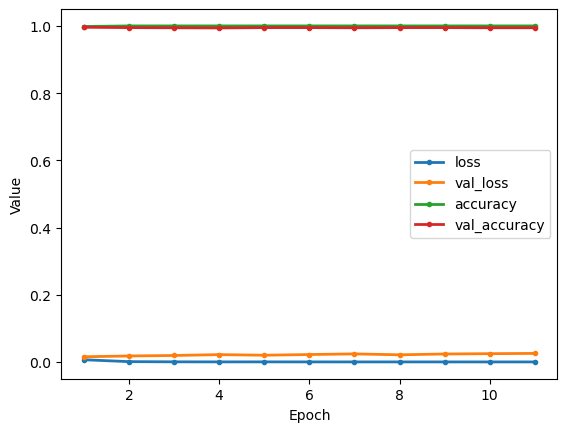

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/79 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step

 6/79 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

11/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

36/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

41/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

47/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

52/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

57/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

62/79 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

67/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

72/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


 1/79 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step

 6/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

36/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

41/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

46/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

51/79 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

57/79 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

62/79 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

67/79 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

73/79 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [25]:
report.save()

Report saved as Output/Reports/Trihelix/report_WPUIF4FS.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################